In [1]:
import numpy as np
import os, itertools, copy, math, random, gc
import matplotlib.pyplot as plt

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torchvision
import torch.nn as nn

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data

from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/AdvancedML/HW2'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1ZmqgtlvZFKVwpSIqNpZ9XKM-FUWkukLU/AdvancedML/HW2


In [3]:
# def clear_cache():
#   global  outputs, targets, protos, logits
#   outputs = None
#   targets = None
#   protos = None
#   logits = None
#   torch.cuda.empty_cache()
#   gc.collect()

# Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])
cifar_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
cifar100 = torch.utils.data.ConcatDataset([cifar_train, cifar_test])
classes = list(range(100))
random.shuffle(classes)
train_classes, val_classes, test_classes = sorted(classes[:70]), sorted(classes[70:90]), sorted(classes[90:])

train_dataset = sorted([d for d in cifar100 if d[1] in train_classes], key=lambda d:d[1])
train_labels = np.repeat(train_classes, 600)
val_dataset = sorted([d for d in cifar100 if d[1] in val_classes], key=lambda d:d[1])
val_labels = np.repeat(val_classes, 600)
test_dataset = sorted([d for d in cifar100 if d[1] in test_classes], key=lambda d:d[1])
test_labels = np.repeat(test_classes, 600)

In [6]:
class BatchSampler(object):
    def __init__(self, labels, classes_per_it, num_support_samples, num_query_samples, iterations, batch_size):
        super(BatchSampler, self).__init__()
        self.labels = labels
        self.classes_per_it = classes_per_it
        self.support_sample_per_class = num_support_samples
        self.query_sample_per_class = num_query_samples
        self.iterations = iterations
        self.batch_size = batch_size

        self.classes = np.unique(self.labels)
        self.indices = np.arange(len(self.labels))

    def __iter__(self):

        for it in range(self.iterations):
            total_batch_indexes = np.array([])

            for _ in range(self.batch_size):
                supports = np.array([], dtype=np.int64)
                queries = np.array([], dtype=np.int64)
                replace = False if self.classes_per_it <= len(self.classes) else True
                sample_classes = np.random.choice(self.classes , size=self.classes_per_it, replace=replace)
                for c in sample_classes:
                    class_samples = np.random.choice(self.indices[self.labels==c], size=self.support_sample_per_class+self.query_sample_per_class, replace=False)
                    supports = np.append(supports, class_samples[0:self.support_sample_per_class])
                    queries = np.append(queries, class_samples[self.support_sample_per_class:])
                #np.random.shuffle(supports)
                #np.random.shuffle(queries)
                total_batch_indexes = np.append(total_batch_indexes, np.append(supports, queries))

            yield total_batch_indexes.astype(int)

    def __len__(self):
        return self.iterations

In [7]:
def get_dataloaders(N_tr, K_tr, Q_tr, N_ts, K_ts, Q_ts):
    
    iterations = 500
    batch_size = 16

    train_sampler = BatchSampler(labels=train_labels, classes_per_it=N_tr,
                                  num_support_samples=K_tr, num_query_samples=Q_tr, iterations=iterations,
                                  batch_size=batch_size)

    val_sampler = BatchSampler(labels=val_labels, classes_per_it=N_tr,
                                  num_support_samples=K_tr, num_query_samples=Q_tr, iterations=iterations,
                                  batch_size=batch_size)

    test_sampler = BatchSampler(labels=test_labels, classes_per_it=N_ts,
                                  num_support_samples=K_ts, num_query_samples=Q_ts, iterations=iterations,
                                  batch_size=batch_size)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_sampler=val_sampler)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_sampler)
    
    return train_dataloader, val_dataloader, test_dataloader

# Model

In [8]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )


class ProtoNet(nn.Module):
    def __init__(self, in_dim=1, hid_dim=64, out_dim=64):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(in_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, hid_dim),
            conv_block(hid_dim, out_dim),
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        return x.view(x.size(0), -1)

# Train

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
def get_device_stat():
  if device.type == 'cuda':
      print(torch.cuda.get_device_name(0))
      print('Memory Usage:')
      print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
      print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda



In [22]:
def distance(protos, outputs):
    # protos: [Batch, N, emb_dim]
    # outputs: [Batch, N*Q, emb_dim]
    NQ = outputs.shape[1]
    N = protos.shape[1]
    protos = torch.repeat_interleave( torch.unsqueeze(protos.detach(), dim=1), NQ, dim=1)
    outputs = torch.repeat_interleave( torch.unsqueeze(outputs, dim=2), N, dim=2)
    return -torch.pow(protos-outputs, 2).sum(dim=-1)
    

def loss_fn(outputs, targets, N, K, Q):
    emb_dim = outputs.shape[-1]
    outputs = outputs.view(-1, N*(K+Q), emb_dim)
    batch_size = outputs.shape[0]
    #targets = targets.view(-1, N*(K+Q))
    if device == 'cpu':
        tensor_cnst = torch.LongTensor
    else:
        tensor_cnst = torch.cuda.LongTensor
    targets = tensor_cnst( np.hstack( [np.repeat(np.arange(N), Q)]*batch_size), device=device)

    protos = torch.mean( outputs[:,:N*K,:].view(batch_size, N, K, emb_dim), dim=2 )
    logits = distance(protos.detach(), outputs[:,N*K:,:]).view(-1, N) #.view(-1, N, Q, outputs.size()[-1]))
    loss = F.cross_entropy(logits, targets)
    
    predictions = torch.argmax(logits, dim=-1)
    acc = torch.sum(predictions == targets)/logits.shape[0]
    
    return loss, acc
    
def train_test(model, N_tr, K_tr, Q_tr, N_ts, K_ts, Q_ts):

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(N_tr, K_tr, Q_tr, N_ts, K_ts, Q_ts)
    
    best_acc, best_state = 0.0, None
    train_loss, train_acc, val_loss, val_acc, test_loss, test_acc = [], [], [], [], [], []


    if model is None:
        model = ProtoNet(in_dim=3, hid_dim=64, out_dim=64).to(device)
        optim = torch.optim.Adam(params=model.parameters(), lr=0.001)

        for epoch in range(3):
            print('=== Epoch: {} ==='.format(epoch+1))

            #Train
            model.train()
            for inputs, labels  in tqdm(train_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optim.zero_grad()

                outputs = model(inputs)
                loss, acc = loss_fn(outputs, labels, N_tr, K_tr, Q_tr)
                loss.backward()

                optim.step()

                train_loss.append(loss.item())
                train_acc.append(acc.item())

                #clear_cache()

            print('Train Loss: {}, Train Acc: {}'.format(np.mean(train_loss), np.mean(train_acc)))

            #clear_cache()
            #get_device_stat()

            #Validation
            model.eval()
            with torch.no_grad():
                for inputs, labels in iter(val_dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)

                    loss, acc = loss_fn(outputs, labels, N_tr, K_tr, Q_tr)

                    val_loss.append(loss.item())
                    val_acc.append(acc.item())
                    
                    #clear_cache()

                print('Val Loss: {}, Val Acc: {}'.format(np.mean(val_loss), np.mean(val_acc)))
                if np.mean(val_acc) >= best_acc:
                    best_acc = np.mean(val_acc)
                    best_state = model.state_dict()
                
        
    #Test
    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()

    with torch.no_grad():
        for inputs, labels in iter(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)

            loss, acc = loss_fn(outputs, labels, N_ts, K_ts, Q_ts)

            test_loss.append(loss.item())
            test_acc.append(acc.item())

            #clear_cache()

        print('Test Acc: {}'.format(np.mean(test_acc)))

    return model, np.mean(test_acc)

## 10-way 8-shot

In [ ]:
model,_ = train_test(model=None, N_tr=10, K_tr=8, Q_tr=8, N_ts=10, K_ts=8, Q_ts=8)

=== Epoch: 1 ===


100%|██████████| 500/500 [07:48<00:00,  1.07it/s]


Train Loss: 1.610353457570076, Train Acc: 0.610512509226799
Val Loss: 1.5080846643447876, Val Acc: 0.5269539182782174
=== Epoch: 2 ===


100%|██████████| 500/500 [07:47<00:00,  1.07it/s]


Train Loss: 1.1194121722280979, Train Acc: 0.7017238385081291
Val Loss: 1.6749366129636765, Val Acc: 0.5300531371533871
=== Epoch: 3 ===


100%|██████████| 500/500 [07:47<00:00,  1.07it/s]


Train Loss: 0.8765434939265251, Train Acc: 0.7600151147445043
Val Loss: 1.947384149312973, Val Acc: 0.5294135539929072
=== Epoch: 4 ===


100%|██████████| 500/500 [07:48<00:00,  1.07it/s]


Train Loss: 0.7428990888595581, Train Acc: 0.7964093860983849
Val Loss: 2.228310157120228, Val Acc: 0.5291052857786417
=== Epoch: 5 ===


100%|██████████| 500/500 [07:48<00:00,  1.07it/s]


Train Loss: 0.6636326555728912, Train Acc: 0.82127438621521
Val Loss: 2.6455072629451752, Val Acc: 0.5264387619853019
Test Acc: 0.5159851682186126


## 10-way x-shot

In [ ]:
shots = [1, 2, 4, 8, 16]
accs_10way_xshot = []
for shot in shots:
    print("\n \033[1;36m --------------- 10-way {}-shot --------------- \033[0m \n".format(shot))
    _, acc = train_test(model=None, N_tr=10, K_tr=shot, Q_tr=shot, N_ts=10, K_ts=shot, Q_ts=shot)
    accs_10way_xshot.append(acc)


  --------------- 10-way 1-shot ---------------  

=== Epoch: 1 ===


100%|██████████| 500/500 [01:13<00:00,  6.78it/s]


Train Loss: 6.6471484515666965, Train Acc: 0.26464375537633894
Val Loss: 2.172147097110748, Val Acc: 0.28222500535845757
=== Epoch: 2 ===


100%|██████████| 500/500 [01:13<00:00,  6.82it/s]


Train Loss: 4.378423909783363, Train Acc: 0.2929093805998564
Val Loss: 2.1186990962028505, Val Acc: 0.2944750052392483
=== Epoch: 3 ===


100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


Train Loss: 3.6192961190541584, Train Acc: 0.3146500059167544
Val Loss: 2.1580859459241233, Val Acc: 0.2972729224761327
=== Epoch: 4 ===


100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


Train Loss: 3.2040637862086294, Train Acc: 0.33744375582039354
Val Loss: 2.211375683426857, Val Acc: 0.3003187560811639
=== Epoch: 5 ===


100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


Train Loss: 2.9227968997955323, Train Acc: 0.35854625598192214
Val Loss: 2.199276253986359, Val Acc: 0.3084275059521198
Test Acc: 0.3405000060796738

  --------------- 10-way 2-shot ---------------  

=== Epoch: 1 ===


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


Train Loss: 3.9020510742664336, Train Acc: 0.3673875053822994
Val Loss: 1.929201773405075, Val Acc: 0.36644688111543655
=== Epoch: 2 ===


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


Train Loss: 2.746218315243721, Train Acc: 0.4231968810111284
Val Loss: 1.902222631573677, Val Acc: 0.38228281849622725
=== Epoch: 3 ===


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


Train Loss: 2.300536768515905, Train Acc: 0.46757709100842476
Val Loss: 1.925258009036382, Val Acc: 0.3949947978258133
=== Epoch: 4 ===


100%|██████████| 500/500 [02:09<00:00,  3.86it/s]


Train Loss: 2.050670349955559, Train Acc: 0.5025382898971439
Val Loss: 2.0010244446992873, Val Acc: 0.39766641245782375
=== Epoch: 5 ===


100%|██████████| 500/500 [02:08<00:00,  3.88it/s]


Train Loss: 1.880064031124115, Train Acc: 0.5330443842828274
Val Loss: 2.1545017256736756, Val Acc: 0.400632506108284
Test Acc: 0.41218438154459

  --------------- 10-way 4-shot ---------------  

=== Epoch: 1 ===


100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Train Loss: 2.7292745084762573, Train Acc: 0.503382821381092
Val Loss: 1.5689890491962433, Val Acc: 0.480023444712162
=== Epoch: 2 ===


100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Train Loss: 1.8753194757699967, Train Acc: 0.5839867289960384
Val Loss: 1.680466390490532, Val Acc: 0.48083438220620156
=== Epoch: 3 ===


 24%|██▍       | 120/500 [00:59<03:07,  2.03it/s]


RuntimeError: ignored

In [ ]:
shots = [4, 8, 16]
accs_10way_4_8_16shot = []
for shot in shots:
    print("\n \033[1;36m --------------- 10-way {}-shot --------------- \033[0m \n".format(shot))
    _, acc = train_test(model=None, N_tr=10, K_tr=shot, Q_tr=shot, N_ts=10, K_ts=shot, Q_ts=shot)
    accs_10way_4_8_16shot.append(acc)


  --------------- 10-way 4-shot ---------------  

=== Epoch: 1 ===


100%|██████████| 500/500 [01:59<00:00,  4.18it/s]


Train Loss: 2.4334900081157684, Train Acc: 0.5061656348705291
Val Loss: 1.6656977939605713, Val Acc: 0.4556734436750412
=== Epoch: 2 ===


100%|██████████| 500/500 [02:02<00:00,  4.09it/s]


Train Loss: 1.7111666682958604, Train Acc: 0.5875531358718872
Val Loss: 1.7498662178516389, Val Acc: 0.4557101624011993
=== Epoch: 3 ===


100%|██████████| 500/500 [02:02<00:00,  4.09it/s]


Train Loss: 1.4010808212359747, Train Acc: 0.6416328234672546
Val Loss: 1.889686593135198, Val Acc: 0.4563770893017451
=== Epoch: 4 ===


100%|██████████| 500/500 [02:02<00:00,  4.09it/s]


Train Loss: 1.2200651787370442, Train Acc: 0.6809500111341477
Val Loss: 2.062238222539425, Val Acc: 0.45675742779672146
=== Epoch: 5 ===


100%|██████████| 500/500 [02:02<00:00,  4.08it/s]


Train Loss: 1.1076082481384277, Train Acc: 0.7106684490203857
Val Loss: 2.3909513850688935, Val Acc: 0.4567140684008598
Test Acc: 0.4573078188896179

  --------------- 10-way 8-shot ---------------  

=== Epoch: 1 ===


100%|██████████| 500/500 [03:56<00:00,  2.12it/s]


Train Loss: 1.557012492418289, Train Acc: 0.6143429798483848
Val Loss: 1.4980509865283966, Val Acc: 0.524736729979515
=== Epoch: 2 ===


100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


Train Loss: 1.0692554189264774, Train Acc: 0.7079011832177639
Val Loss: 1.7419520989656447, Val Acc: 0.5155671979188919
=== Epoch: 3 ===


100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


Train Loss: 0.845307846903801, Train Acc: 0.7630065221587817
Val Loss: 1.9712654794851938, Val Acc: 0.5114968849817911
=== Epoch: 4 ===


100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


Train Loss: 0.7161047545075416, Train Acc: 0.7990250120908022
Val Loss: 2.366900453031063, Val Acc: 0.5076937596350908
=== Epoch: 5 ===


100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


Train Loss: 0.6339175264000892, Train Acc: 0.8242312622189522
Val Loss: 2.690688699102402, Val Acc: 0.5047595404267311
Test Acc: 0.4922859449386597

  --------------- 10-way 16-shot ---------------  

=== Epoch: 1 ===


  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: ignored

In [20]:
shots = [16]
accs_10way_16shot = []
for shot in shots:
    print("\n \033[1;36m --------------- 10-way {}-shot --------------- \033[0m \n".format(shot))
    _, acc = train_test(model=None, N_tr=10, K_tr=shot, Q_tr=shot, N_ts=10, K_ts=shot, Q_ts=shot)
    accs_10way_16shot.append(acc)



  --------------- 10-way 16-shot ---------------  

=== Epoch: 1 ===


100%|██████████| 500/500 [07:40<00:00,  1.09it/s]


Train Loss: 1.4019836647510528, Train Acc: 0.6564086043238639
Val Loss: 1.4526196014881134, Val Acc: 0.5398343865871429
=== Epoch: 2 ===


100%|██████████| 500/500 [07:40<00:00,  1.09it/s]


Train Loss: 0.959437124401331, Train Acc: 0.7440914179980754
Val Loss: 1.7050571439266204, Val Acc: 0.5333632936775684
=== Epoch: 3 ===


100%|██████████| 500/500 [07:41<00:00,  1.08it/s]


Train Loss: 0.7481446996231874, Train Acc: 0.795235168437163
Val Loss: 1.9200535941123962, Val Acc: 0.5328528765837351
=== Epoch: 4 ===


100%|██████████| 500/500 [07:41<00:00,  1.08it/s]


Train Loss: 0.6228386105448007, Train Acc: 0.8285554809123278
Val Loss: 2.1271838631629945, Val Acc: 0.5321800896674395
=== Epoch: 5 ===


100%|██████████| 500/500 [07:41<00:00,  1.08it/s]


Train Loss: 0.537751970410347, Train Acc: 0.8520359492182732
Val Loss: 2.307511975479126, Val Acc: 0.5316934492826462
Test Acc: 0.530248448729515


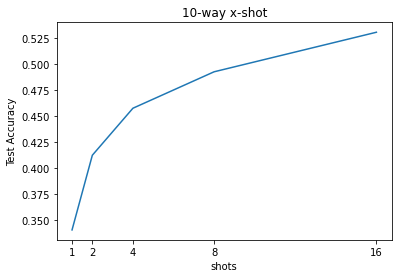

In [27]:
shots = [1, 2, 4, 8, 16]
test_accs = [0.3405, 0.41218438154459, 0.4573078188896179, 0.4922859449386597, 0.530248448729515]
plt.plot(shots, test_accs)
plt.xlabel("shots")
plt.xticks(shots, shots)
plt.ylabel("Test Accuracy")
_ = plt.title("10-way x-shot")

## x-way 5-shot

In [34]:
ways = [2, 4, 8, 16, 32]
accs_xway_5shot = []
for way in ways:
    print("\n--------------- {}-way 5-shot ---------------\n".format(way))
    _, acc = train_test(model=None, N_tr=way, K_tr=5, Q_tr=5, N_ts=10, K_ts=5, Q_ts=5)
    accs_xway_5shot.append(acc)


--------------- 2-way 5-shot ---------------

=== Epoch: 1 ===


100%|██████████| 500/500 [00:40<00:00, 12.36it/s]


Train Loss: 2.3163123465180395, Train Acc: 0.769550012588501
Val Loss: 0.561148843228817, Val Acc: 0.7665875113010406
=== Epoch: 2 ===


100%|██████████| 500/500 [00:40<00:00, 12.37it/s]


Train Loss: 1.4200590221136808, Train Acc: 0.7843875118494034
Val Loss: 0.5218373962938786, Val Acc: 0.7778750123381615
=== Epoch: 3 ===


100%|██████████| 500/500 [00:40<00:00, 12.37it/s]


Train Loss: 1.0887448186874389, Train Acc: 0.7984291785160701
Val Loss: 0.4914064271946748, Val Acc: 0.7880500120321909
=== Epoch: 4 ===


100%|██████████| 500/500 [00:40<00:00, 12.33it/s]


Train Loss: 0.9148705079257489, Train Acc: 0.8090718867778778
Val Loss: 0.47232301443815233, Val Acc: 0.7933031368553638
=== Epoch: 5 ===


100%|██████████| 500/500 [00:40<00:00, 12.37it/s]


Train Loss: 0.804687932497263, Train Acc: 0.8186200118780136
Val Loss: 0.4632789882004261, Val Acc: 0.7960350119113923
Test Acc: 0.37704499101638794

--------------- 4-way 5-shot ---------------

=== Epoch: 1 ===


100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


Train Loss: 2.5299346914291383, Train Acc: 0.6223062628507614
Val Loss: 1.049308232307434, Val Acc: 0.607443761587143
=== Epoch: 2 ===


100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


Train Loss: 1.6917831877470015, Train Acc: 0.6620625120401382
Val Loss: 1.0288673897385596, Val Acc: 0.6120468865036964
=== Epoch: 3 ===


100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


Train Loss: 1.3575670099854469, Train Acc: 0.6939500121275584
Val Loss: 0.983660722454389, Val Acc: 0.6275437619686127
=== Epoch: 4 ===


100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


Train Loss: 1.1725277248024941, Train Acc: 0.7173468873500825
Val Loss: 0.9725181518793106, Val Acc: 0.6355000117719174
=== Epoch: 5 ===


100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


Train Loss: 1.0508573695898056, Train Acc: 0.7356775121688843
Val Loss: 0.9626785023927689, Val Acc: 0.6448187618970871
Test Acc: 0.4557149892449379

--------------- 8-way 5-shot ---------------

=== Epoch: 1 ===


100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


Train Loss: 3.0188203778266907, Train Acc: 0.5140937602519989
Val Loss: 1.560412429332733, Val Acc: 0.4714062556028366
=== Epoch: 2 ===


100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


Train Loss: 2.056741349220276, Train Acc: 0.5795453233718872
Val Loss: 1.5314602891206741, Val Acc: 0.4880421948730946
=== Epoch: 3 ===


100%|██████████| 500/500 [02:07<00:00,  3.93it/s]


Train Loss: 1.660739570816358, Train Acc: 0.6255375111897786
Val Loss: 1.4966796896457673, Val Acc: 0.5014666756391525
=== Epoch: 4 ===


100%|██████████| 500/500 [02:07<00:00,  3.93it/s]


Train Loss: 1.4259829416722059, Train Acc: 0.6606773551106453
Val Loss: 1.6456875405907632, Val Acc: 0.5017125091552734
=== Epoch: 5 ===


100%|██████████| 500/500 [02:08<00:00,  3.91it/s]


Train Loss: 1.2786872265696525, Train Acc: 0.6867662615060807
Val Loss: 1.666660415506363, Val Acc: 0.5046837595582009
Test Acc: 0.4431824896931648

--------------- 16-way 5-shot ---------------

=== Epoch: 1 ===


100%|██████████| 500/500 [04:05<00:00,  2.03it/s]


Train Loss: 2.6933495819568636, Train Acc: 0.4428546946644783
Val Loss: 2.0597226943969726, Val Acc: 0.35903594380617143
=== Epoch: 2 ===


100%|██████████| 500/500 [04:06<00:00,  2.03it/s]


Train Loss: 1.9494090982079506, Train Acc: 0.5358609468638897
Val Loss: 2.1660419890880585, Val Acc: 0.36503047502040864
=== Epoch: 3 ===


100%|██████████| 500/500 [04:04<00:00,  2.04it/s]


Train Loss: 1.6045245827436447, Train Acc: 0.5998604271213214
Val Loss: 2.400644223690033, Val Acc: 0.3666156312028567
=== Epoch: 4 ===


100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


Train Loss: 1.420179098635912, Train Acc: 0.6446300888508558
Val Loss: 2.9463299094438553, Val Acc: 0.36727695931494236
=== Epoch: 5 ===


100%|██████████| 500/500 [04:04<00:00,  2.05it/s]


Train Loss: 1.3344518563508987, Train Acc: 0.6775096986174584
Val Loss: 3.7940362294197083, Val Acc: 0.36883156850337984
Test Acc: 0.4344124902486801

--------------- 32-way 5-shot ---------------

=== Epoch: 1 ===


100%|██████████| 500/500 [08:08<00:00,  1.02it/s]

Train Loss: 3.099352857351303, Train Acc: 0.4041562570929527


ValueError: ignored

In [41]:
ways = [32]
for way in ways:
    print("\n--------------- {}-way 5-shot ---------------\n".format(way))
    _, acc = train_test(model=None, N_tr=way, K_tr=5, Q_tr=5, N_ts=10, K_ts=5, Q_ts=5)
    accs_xway_5shot.append(acc)


--------------- 32-way 5-shot ---------------

=== Epoch: 1 ===


100%|██████████| 500/500 [08:30<00:00,  1.02s/it]


Train Loss: 2.8475135333538057, Train Acc: 0.3972281315922737
Val Loss: 3.135453097343445, Val Acc: 0.18420234701037408
=== Epoch: 2 ===


100%|██████████| 500/500 [08:27<00:00,  1.02s/it]


Train Loss: 2.0556152745485305, Train Acc: 0.5197894625365734
Val Loss: 4.040764589786529, Val Acc: 0.18183945639431476
=== Epoch: 3 ===


100%|██████████| 500/500 [08:28<00:00,  1.02s/it]


Train Loss: 1.7589312054316202, Train Acc: 0.5991679789026578
Val Loss: 6.639471158027649, Val Acc: 0.182529430270195
=== Epoch: 4 ===


100%|██████████| 500/500 [08:27<00:00,  1.02s/it]


Train Loss: 1.713592797100544, Train Acc: 0.6535603622943162
Val Loss: 9.745644043684006, Val Acc: 0.1815968781337142
=== Epoch: 5 ===


100%|██████████| 500/500 [08:27<00:00,  1.02s/it]


Train Loss: 1.7950346096992493, Train Acc: 0.6961529797911644
Val Loss: 16.30378082027435, Val Acc: 0.18104125312566757
Test Acc: 0.4231824904680252


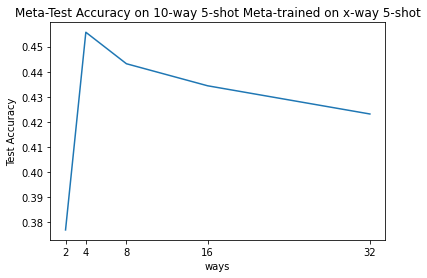

In [42]:
ways = [2, 4, 8, 16, 32]
plt.plot(ways, accs_xway_5shot)
plt.xlabel("ways")
plt.xticks(ways, ways)
plt.ylabel("Test Accuracy")
_ = plt.title("Meta-Test Accuracy on 10-way 5-shot Meta-trained on x-way 5-shot")

sfgs

## metatrain 10-way 10-shot  |  x-shot metatest

In [17]:
model_10way_10shot, _ = train_test(model=None, N_tr=10, K_tr=10, Q_tr=10, N_ts=10, K_ts=10, Q_ts=10)

=== Epoch: 1 ===


100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


Train Loss: 1.749773250222206, Train Acc: 0.588087485909462
Val Loss: 1.4455127930641174, Val Acc: 0.5198249879479409
=== Epoch: 2 ===


100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


Train Loss: 1.2349267844557763, Train Acc: 0.6727756090760231
Val Loss: 1.5664675096273422, Val Acc: 0.5188956133425235
=== Epoch: 3 ===


100%|██████████| 500/500 [06:21<00:00,  1.31it/s]


Train Loss: 0.982918768465519, Train Acc: 0.7285453993082046
Val Loss: 1.7589581509431202, Val Acc: 0.5168308219909667
Test Acc: 0.5546874874830245


UnboundLocalError: ignored

In [24]:
metatest_shots = [1, 5, 10, 15, 20]
accs_metatest_10way_xshot = []
for shot in metatest_shots:
    print("\n \033[1;36m --------------- 10-way {}-shot --------------- \033[0m \n".format(shot))
    _, acc = train_test(model=model_10way_10shot, N_tr=10, K_tr=shot, Q_tr=shot, N_ts=10, K_ts=shot, Q_ts=shot)
    accs_metatest_10way_xshot.append(acc)


  --------------- 10-way 1-shot ---------------  

Test Acc: 0.3257250053286552

  --------------- 10-way 5-shot ---------------  

Test Acc: 0.5049224869012833

  --------------- 10-way 10-shot ---------------  

Test Acc: 0.5553574873209

  --------------- 10-way 15-shot ---------------  

Test Acc: 0.5759125131368638

  --------------- 10-way 20-shot ---------------  

Test Acc: 0.5876587370634079


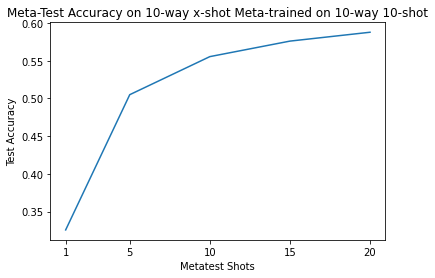

In [25]:
plt.plot(metatest_shots, accs_metatest_10way_xshot)
plt.xlabel("Metatest Shots")
plt.xticks(metatest_shots, metatest_shots)
plt.ylabel("Test Accuracy")
_ = plt.title("Meta-Test Accuracy on 10-way x-shot Meta-trained on 10-way 10-shot")